In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

##### Import Dataset

In [65]:
df_original = pd.read_csv('output\dataset_worldbank_transposed.csv')
df_original

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16221,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16222,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16223,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16224,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Remove Noisy Country

In [66]:
countries_to_drop = ['Channel Islands',
 'Curacao',
 'Isle of Man',
 'Kosovo',
 'Monaco',
 'Northern Mariana Islands',
 'Not classified',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'South Sudan',
 'St. Martin (French part)']

df_original = df_original[~df_original['Country Name'].isin(countries_to_drop)]
df_original

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16221,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16222,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16223,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16224,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Drop Missing Values > 50%

In [67]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=True):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                      y="variable",
                      hue="missing",
                      multiple="fill",
                      height=10,
                      aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

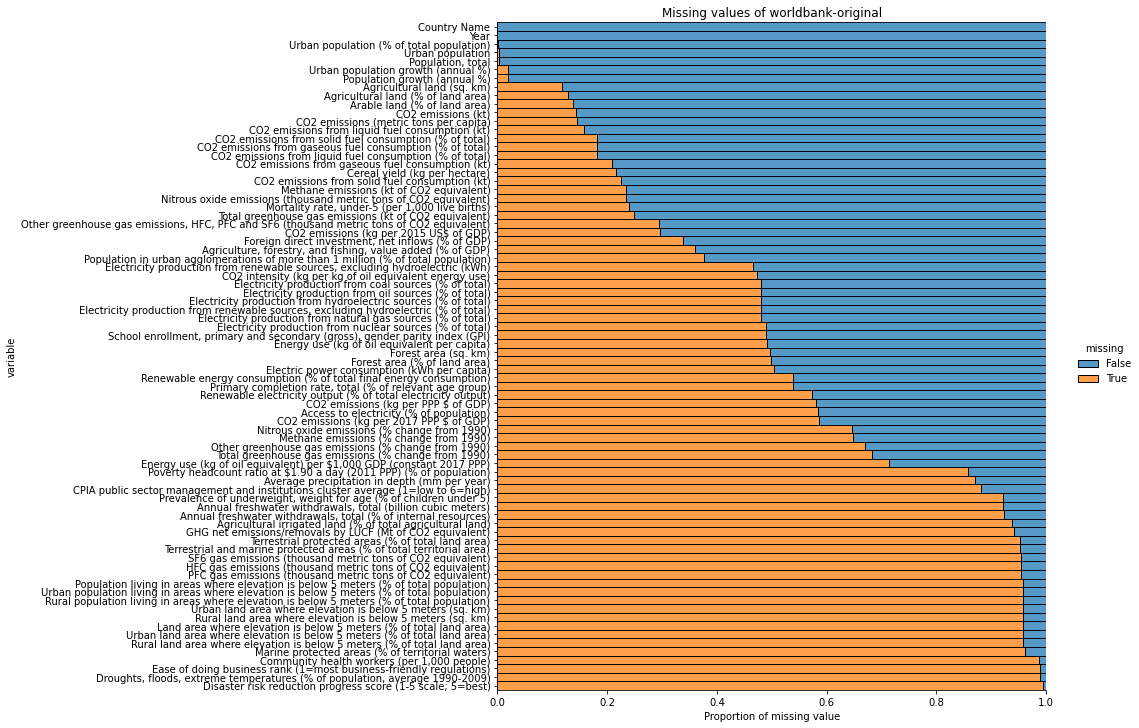

In [68]:
visual_nan(df_original, 'worldbank-original', isSorted=True)

In [69]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
missing_ratio_summary(df_original)

,col,missing,ratio
0,Country Name,0,0.00
1,Year,0,0.00
2,Urban population (% of total population),9,0.06
3,Urban population,42,0.27
5,"Population, total",42,0.27
...,...,...,...
17,Marine protected areas (% of territorial waters),14961,96.18
9,"Community health workers (per 1,000 people)",15342,98.63
15,Ease of doing business rank (1=most business-f...,15369,98.80
25,"Droughts, floods, extreme temperatures (% of p...",15387,98.92


In [70]:
missing = pd.DataFrame(df_original.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df_original)*100).round(2)
missing_list = missing[missing['ratio'] > 50]['col'].tolist()
missing_list

['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Community health workers (per 1,000 people)',
 'Primary completion rate, total (% of relevant age group)',
 'CPIA public sector management and institutions cluster average (1=low to 6=high)',
 'Ease of doing business rank (1=most business-friendly regulations)',
 'Terrestrial and marine protected areas (% of total territorial area)',
 'Marine protected areas (% of territorial waters)',
 'Terrestrial protected areas (% of total land area)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Population living in areas where elevation is below 5 meters (% of total population)',
 'Urban population living in areas where elevation is below 5 meters (% of total population)',
 'Rural population living in areas where elevation is below 5 meters (% of total population)',
 '

In [71]:
df_original = df_original.drop(columns=missing_list)

In [72]:
# Remove CO2 columns
y_cols = [c for c in df_original.columns if c.lower()[:13] == 'co2 emissions']
y_cols

['CO2 emissions from solid fuel consumption (% of total)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (metric tons per capita)',
 'CO2 emissions from liquid fuel consumption (% of total)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions (kg per 2015 US$ of GDP)',
 'CO2 emissions from gaseous fuel consumption (% of total)',
 'CO2 emissions from gaseous fuel consumption (kt)']

In [73]:
# df_original.drop(col_list, 1)

In [74]:
col_list = [col for col in df_original.columns.tolist() if df_original[col].dtype.name == "object"]
df_oh = df_original[col_list]
df = df_original.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df, df_oh], axis=1)
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [75]:
cols = [c for c in df.columns if c.lower()[:13] != 'co2 emissions']
df = df[df.columns.intersection(cols)]
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# def multivariate_imputation(df, iso_code, country):
    
#     N = 20
#     df_train = df.iloc[:-N] 
#     df_test = df[-N:] # last N years

#     print(f'Training years: {df_train.shape[0]}')
#     print(f'Test years: {df_test.shape[0]}')
    
#     visual_nan(df_train.shape[0], name="", isSorted=False, savePlot=True)
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df_train.iloc[:, :49]) # exclude last column

#     df_predict_array = imp.transform(df_test.iloc[:, :49])

#     columns = df.columns.tolist()[:49]
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df
    
#     df_predict['iso_code'] = iso_code
#     df_predict['country'] = country
#     df_predict['year'] = df_test['Year'].to_list() # predicted years

#     return df_predict

In [77]:
rf =RandomForestRegressor(n_jobs=-1, max_depth =64)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state = 1)

In [78]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [79]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
df = pd.DataFrame(x_scaled)

In [80]:
# import pandas as pd
# import numpy as np

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.fillna(0, inplace=True)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # return df[indices_to_keep].astype(np.float64)

In [81]:
# clean_dataset(df)
df.fillna(0, inplace=True)
df.head()
# X.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,0.000000,0.497319,0.000006,0.000000,0.000006,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016667,0.497166,0.000006,0.802059,0.000007,0.368966,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.033333,0.497013,0.000006,0.798663,0.000007,0.336030,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.050000,0.496850,0.000006,0.796055,0.000007,0.311056,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.496696,0.000006,0.795049,0.000007,0.301090,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
y = df_original['CO2 emissions (metric tons per capita)'].fillna(0)
X = df
colnames = X.columns

In [83]:
feat_selector.fit(X.values, y.values.ravel())
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [84]:
print('---------Top 10 for CO2 emissions (metric tons per capita)----------')
display(boruta_score.head(11))

print('---------Bottom 10 for CO2 emissions (metric tons per capita)----------')
boruta_score.tail(10)

---------Top 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
0,Year,1.00
12,Total greenhouse gas emissions (kt of CO2 equi...,1.00
42,Country Name_Aruba,1.00
1,Urban population (% of total population),1.00
28,Agricultural land (% of land area),1.00
15,Energy use (kg of oil equivalent per capita),1.00
14,CO2 intensity (kg per kg of oil equivalent ene...,1.00
223,Country Name_Qatar,1.00
2,Urban population,1.00
5,Population growth (annual %),1.00


---------Bottom 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
186,Country Name_Middle East & North Africa (IDA &...,0.03
249,Country Name_Sub-Saharan Africa (IDA & IBRD co...,0.03
73,Country Name_Chad,0.02
226,Country Name_Rwanda,0.02
202,Country Name_Niger,0.01
248,Country Name_Sub-Saharan Africa,0.01
63,Country Name_Burkina Faso,0.01
266,Country Name_Turks and Caicos Islands,0.00
241,Country Name_South Asia,0.00
122,Country Name_Guam,0.00


Text(0.5, 1.0, 'Boruta all Features')

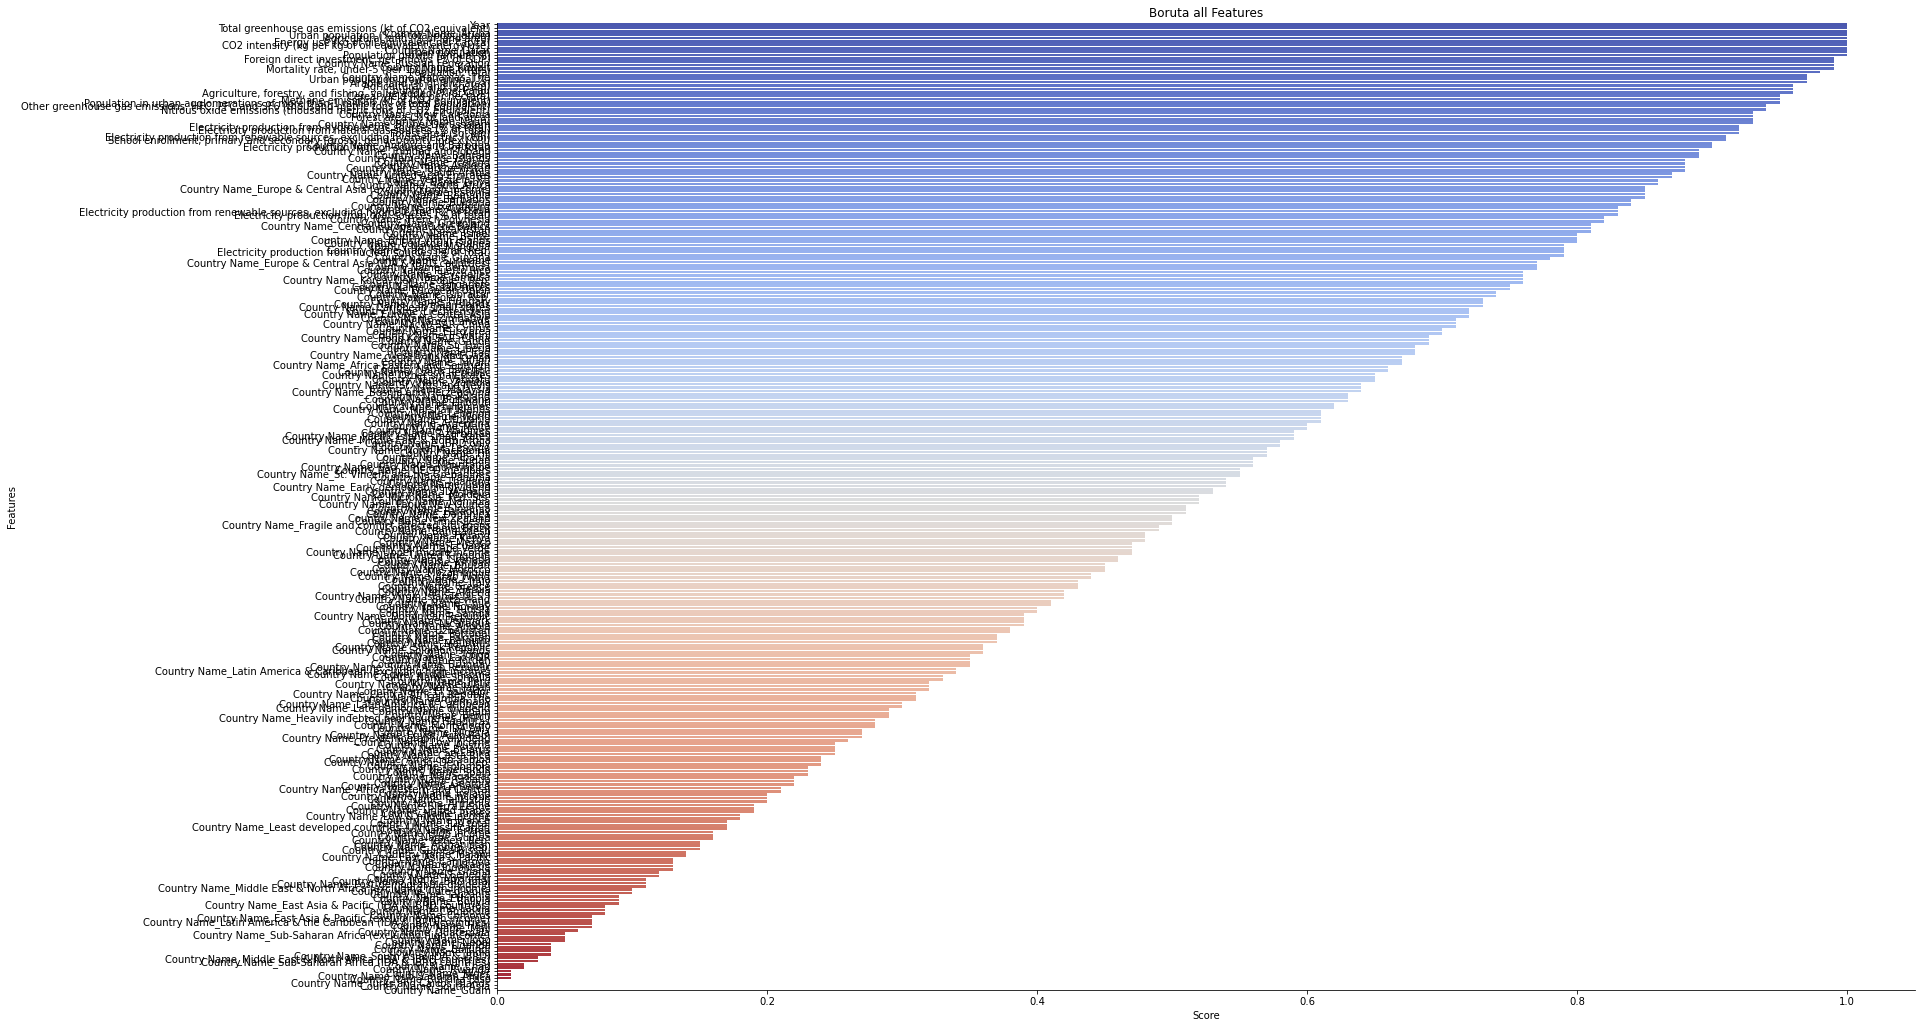

In [85]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta all Features")

In [86]:
boruta_score.head(11)['Features'].values

array(['Year', 'Total greenhouse gas emissions (kt of CO2 equivalent)',
       'Country Name_Aruba', 'Urban population (% of total population)',
       'Agricultural land (% of land area)',
       'Energy use (kg of oil equivalent per capita)',
       'CO2 intensity (kg per kg of oil equivalent energy use)',
       'Country Name_Qatar', 'Urban population',
       'Population growth (annual %)',
       'Foreign direct investment, net inflows (% of GDP)'], dtype=object)

In [89]:
cols_to_keep = np.delete(boruta_score.head(11)['Features'].values, [0, 2, 7])
#Remove Cols that should not be in final dataset
df_final = df_original[cols_to_keep]
df_final

,Total greenhouse gas emissions (kt of CO2 equivalent),Urban population (% of total population),Agricultural land (% of land area),Energy use (kg of oil equivalent per capita),CO2 intensity (kg per kg of oil equivalent energy use),Urban population,Population growth (annual %),"Foreign direct investment, net inflows (% of GDP)"
0,NaN,50.776,NaN,NaN,NaN,27525.0,NaN,NaN
1,NaN,50.761,11.111111,NaN,NaN,28139.0,2.236462,NaN
2,NaN,50.746,11.111111,NaN,NaN,28537.0,1.432843,NaN
3,NaN,50.730,11.111111,NaN,NaN,28763.0,0.823502,NaN
4,NaN,50.715,11.111111,NaN,NaN,28922.0,0.580334,NaN
...,...,...,...,...,...,...,...,...
16221,29120.0,32.296,41.876696,NaN,NaN,4531238.0,1.549294,1.669274
16222,28800.0,32.237,41.876696,NaN,NaN,4589452.0,1.459406,1.299939
16223,31380.0,32.209,41.876696,NaN,NaN,4650597.0,1.410382,3.814032
16224,NaN,32.210,NaN,NaN,NaN,4717307.0,1.421142,1.653631
